# COMP9417 230T2  Homework 2: Applying and Implementing Machine Learning

_Mon 27 Jul 2020 18:21:08 AEST_

The aim of this homework is to enable you to:

- **apply** parameter search for machine learning algorithms implemented in the Python [scikit-learn](http://scikit-learn.org/stable/index.html) machine learning library
- answer questions based on your **analysis** and **interpretation** of the empirical results of such applications, using your knowledge of machine learning
- **complete** an implementation of a different version of a learning algorithm you have previously seen

After completing this homework you will be able to:

- set up a simple grid search over different hyper-parameter settings based on $k$-fold cross-validation to obtain  performance measures on different datasets
- compare the performance measures of different algorithm settings 
- propose properties of algorithms and their hyper-parameters, or datasets, which
  may lead to performance differences being observed
- suggest reasons for actual observed performance differences in terms of
  properties of algorithms, parameter settings or datasets.
- read and understand incomplete code for a learning algorithm to the point of being able to complete the implementation and run it successfully on a dataset.

There are a total of *10 marks* available.
Each homework mark is worth *0.5 course mark*, i.e., homework marks will be scaled
to a **course mark out of 5** to contribute to the course total.

Deadline: 11:59:59, Thursday August  6, 2020.

Submission will be via the CSE *give* system (see below).

Late penalties: one mark will be deducted from the total for each day late, up to a total of five days. If six or more days late, no marks will be given.

Recall the guidance regarding plagiarism in the course introduction: this applies to this homework and if evidence of plagiarism is detected it may result in penalties ranging from loss of marks to suspension.

### Format of the questions

There are 2 questions in this homework. Question 1 requires answering some multiple-choice questions in the file [*answers.txt*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/answers.txt). Both questions require you to copy and paste text into the file [*answers.txt*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/answers.txt). This file **MUST CONTAIN ONLY PLAIN TEXT WITH NO SPECIAL CHARACTERS**.

This file will form your submission.

In summary, your submission will comprise a single file which should be named as follows:
```
answers.txt
```
Please note: files in any format other than plain text **cannot be accepted**.

Submit your files using ```give```. On a CSE Linux machine, type the following on the command-line:
```
$ give cs9417 hw2 answers.txt
```

Alternatively, you can submit using the web-based interface to ```give```.

### Datasets

The datasets required for the homework can be downloaded [*here*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/datasets.zip).
Note: you will need to ensure the dataset files are in the same directory from which you are running this notebook.

**Please Note**: this homework uses some datasets in the Attribute-Relation File Format (.arff). To load datasets from '.arff' formatted files, you will need to have installed the ```liac-arff``` package. You can do this using ```pip``` at the command-line, as follows:

```
$ pip install liac-arff
```

## Question 1 – Overfitting avoidance [Total: 3 marks]

Dealing with noisy data is a key issue in machine learning. Unfortunately, even algorithms that have noise-handling mechanisms built-in, like decision trees, can overfit noisy data, unless their "overfitting avoidance" or *regularization* hyper-parameters are set properly.

You will be using datasets that have had various amounts of "class noise" added
by randomly changing the actual class value to a different one for a
specified percentage of the training data.
Here we will specify three arbitrarily chosen levels of noise: low
($20\%$), medium ($50\%$) and high ($80\%$).
The learning algorithm must try to "see through" this noise and learn
the best model it can, which is then evaluated on test data *without*
added noise to evaluate how well it has avoided fitting the noise.

We will also let the algorithm do a limited _grid search_ using cross-validation
for the best *over-fitting avoidance* parameter settings on each training set.

### Running the classifiers

**1(a). [1 mark]** 

Run the code section in the notebook cells below. This will generate a table of results, which you should copy and paste **WITHOUT MODIFICATION** into the file [*answers.txt*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/answers.txt)
as your answer for "Question 1(a)". 

The output of the code section is a table, which represents the percentage accuracy of classification for the decision tree algorithm. The first column contains the result of the "Default" classifier, which is the decision tree algorithm with default parameter settings running on each of the datasets which have had $50\%$ noise added. From the second column on, in each column the results are obtained by running the decision tree algorithm on $0\%$, $20\%$, $50\%$ and $80\%$ noise added to each of the datasets, and in the parentheses is shown the result of a [grid search](http://en.wikipedia.org/wiki/Hyperparameter_optimization) that has been applied to determine the best value for a basic parameter of the decision tree algorithm, namely [min_samples_leaf](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) i.e., the minimum number of examples that can be used to make a prediction in the tree, on that dataset. 

### Result interpretation
Answer these questions in the file called [*answers.txt*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/answers.txt). Your answers must be based on the results table you saved in "Question 1(a)".

**1(b). [1 mark]** Refer to [*answers.txt*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/answers.txt).

**1(c). [1 mark]** Refer to [*answers.txt*](http://www.cse.unsw.edu.au/~cs9417/20T2/hw2/answers.txt).

### Code for question 1

It is only necessary to run the following code to answer the question, but you should also go through it to make sure you know what is going on.

In [1]:
# Code for question 1

import arff, numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import sys
import warnings

In [2]:
# fixed random seed
np.random.seed(1)

def warn(*args, **kwargs):
    pass

def label_enc(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    return le

def features_encoders(features,categorical_features='all'):
    n_samples, n_features = features.shape
    label_encoders = [preprocessing.LabelEncoder() for _ in range(n_features)]

    X_int = np.zeros_like(features, dtype=np.int)

    for i in range(n_features):
        feature_i = features[:, i]
        label_encoders[i].fit(feature_i)
        X_int[:, i] = label_encoders[i].transform(feature_i)
        
    enc = preprocessing.OneHotEncoder(categorical_features=categorical_features)
    return enc.fit(X_int),label_encoders

def feature_transform(features,label_encoders, one_hot_encoder):
    
    n_samples, n_features = features.shape
    X_int = np.zeros_like(features, dtype=np.int)
    
    for i in range(n_features):
        feature_i = features[:, i]
        X_int[:, i] = label_encoders[i].transform(feature_i)

    return one_hot_encoder.transform(X_int).toarray()

warnings.warn = warn

In [3]:
class DataFrameImputer(TransformerMixin):

    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


def load_data(path):
    dataset = arff.load(open(path, 'r'))
    data = np.array(dataset['data'])
    data = pd.DataFrame(data)
    data = DataFrameImputer().fit_transform(data).values
    attr = dataset['attributes']

    # mask categorical features
    masks = []
    for i in range(len(attr)-1):
        if attr[i][1] != 'REAL':
            masks.append(i)
    return data, masks

def preprocess(data,masks, noise_ratio):
    # split data
    train_data, test_data = train_test_split(data,test_size=0.3,random_state=0)

    # test data
    test_features = test_data[:,0:test_data.shape[1]-1]
    test_labels = test_data[:,test_data.shape[1]-1]

    # training data
    features = train_data[:,0:train_data.shape[1]-1]
    labels = train_data[:,train_data.shape[1]-1]

    classes = list(set(labels))
    # categorical features need to be encoded
    if len(masks):
        one_hot_enc, label_encs = features_encoders(data[:,0:data.shape[1]-1],masks)
        test_features = feature_transform(test_features,label_encs,one_hot_enc)
        features = feature_transform(features,label_encs,one_hot_enc)

    le = label_enc(data[:,data.shape[1]-1])
    labels = le.transform(train_data[:,train_data.shape[1]-1])
    test_labels = le.transform(test_data[:,test_data.shape[1]-1])
    
    # add noise
    np.random.seed(1234)
    noise = np.random.randint(len(classes)-1, size=int(len(labels)*noise_ratio))+1
    
    noise = np.concatenate((noise,np.zeros(len(labels) - len(noise),dtype=np.int)))
    labels = (labels + noise) % len(classes)

    return features,labels,test_features,test_labels

In [4]:
# load data
paths = ['balance-scale','primary-tumor',
         'glass','heart-h']
noise = [0,0.2,0.5,0.8]

scores = []
params = []

for path in paths:
    score = []
    param = []
    path += '.arff'
    data, masks = load_data(path)
    
    # training on data with 50% noise and default parameters
    features, labels, test_features, test_labels = preprocess(data, masks, 0.5)
    tree = DecisionTreeClassifier(random_state=0,min_samples_leaf=2, min_impurity_decrease=0)
    tree.fit(features, labels)
    tree_preds = tree.predict(test_features)
    tree_performance = accuracy_score(test_labels, tree_preds)
    score.append(tree_performance)
    param.append(tree.get_params()['min_samples_leaf'])
    
    # training on data with noise levels of 0%, 20%, 50% and 80%
    for noise_ratio in noise:
        features, labels, test_features, test_labels = preprocess(data, masks, noise_ratio)
        param_grid = {'min_samples_leaf': np.arange(2,30,5)}

        grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid,cv=10,return_train_score=True)
        grid_tree.fit(features, labels)

        estimator = grid_tree.best_estimator_
        tree_preds = grid_tree.predict(test_features)
        tree_performance = accuracy_score(test_labels, tree_preds)
        score.append(tree_performance)
        param.append(estimator.get_params()['min_samples_leaf'])

    scores.append(score)
    params.append(param)

# print the results
header = "{:^112}".format("Decision Tree Results") + '\n' + '-' * 112  + '\n' + \
"{:^15} | {:^16} | {:^16} | {:^16} | {:^16} | {:^16} |".format("Dataset", "Default", "0%", "20%", "50%", "80%") + \
 '\n' + '-' * 112  + '\n'

# print result table
print(header)
for i in range(len(scores)):
    #scores = score_list[i][1]
    print("{:<16}".format(paths[i]),end="")
    for j in range(len(params[i])):
        print("|  {:>6.2%} ({:>2})     " .format(scores[i][j],params[i][j]),end="")
    print('|\n')
print('\n')

                                             Decision Tree Results                                              
----------------------------------------------------------------------------------------------------------------
    Dataset     |     Default      |        0%        |       20%        |       50%        |       80%        |
----------------------------------------------------------------------------------------------------------------

balance-scale   |  36.70% ( 2)     |  76.06% ( 2)     |  71.28% (12)     |  65.43% (27)     |  18.09% (27)     |

primary-tumor   |  25.49% ( 2)     |  37.25% (12)     |  42.16% (12)     |  43.14% (12)     |  26.47% ( 7)     |

glass           |  44.62% ( 2)     |  69.23% ( 7)     |  66.15% (22)     |  35.38% (17)     |  29.23% (17)     |

heart-h         |  35.96% ( 2)     |  67.42% ( 7)     |  78.65% (22)     |  56.18% (17)     |  20.22% (27)     |





## Question 2 – Implementation of a simple RNN [Total: 7 marks]

In this question, you will implement a simple recurrent neural network (RNN).

Recurrent neural networks are commonly used when the input data has temporal dependencies among consecutive observations, for example time series and text data. With such data, having knowledge of the previous data points in addition to the current helps in prediction.

## Recurrent neural networks

RNNs are suitable in such scenarios because they keep a state derived from all previously seen data, which in combination with the current input is used to predict the output.

In general, recurrent neural networks work like the following:

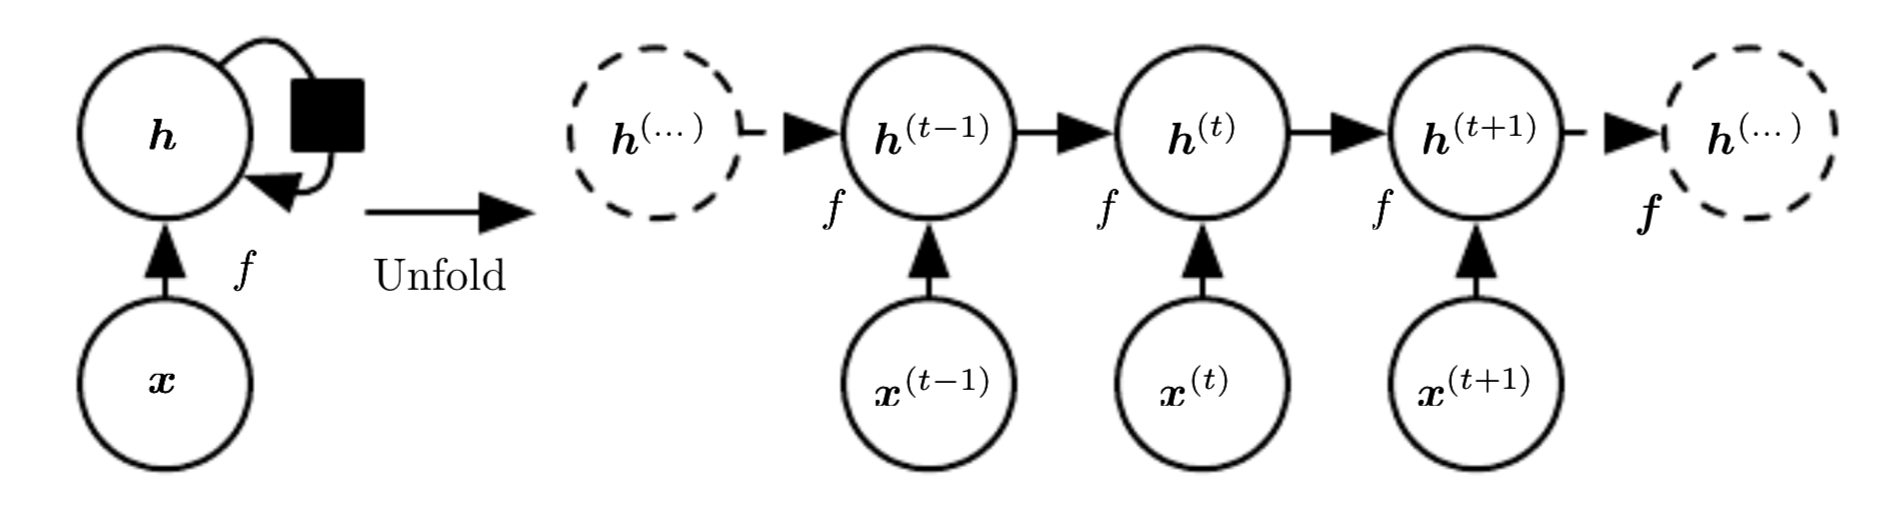
_(Image credit: Goodfellow, Bengio & Courville (2015) - Deep Learning)_

Here, $x$ is the input, and $h$ is the hidden state maintained by the RNN. For each input in the sequence, the RNN takes both the previous state $h_{t-1}$ and the current input $x_t$ to do the prediction.

Notice there is only one set of weights in the RNN, but this set of weights is used for the whole sequence of input. In effect, the RNN is chained with itself a number of times equalling the length of the input.

Thus for the purpose of training the RNN, a common practice is to unfold the computational graph, and run the standard back-propagation thereon. This technique is also known as back-propagation through time.

## Your task

Given a dataset of partial words (words without the last character), your task is to implement an RNN to predict the last character in the word. Specifically, your RNN will have the first 9 characters of a word as its input, and you need to predict the 10th character. If there are fewer than 10 characters in a word, spaces are used to pad it.

Most of the code needed is provided below, what you need to do is to implement the back-propagation through time section in ```NeuralNetwork.fit()```.

There are four sections marked ```TO DO: ``` where you need to add your own code to complete a working implementation.

**HINT:** review the implementation of the ```backpropagate``` method of the ```NeuralNetwork``` class in the code in the notebook for Lab6 on "Neural Learning". That should give you a starting point for your implementation.

Ensure that you have the following files you need for training and testing in the directory in which you run this notebook:
```
training_input.txt
training_label.txt
testing_input.txt
testing_label.txt
```

**HINT:** if your implementation is correct your output should look something like the following:

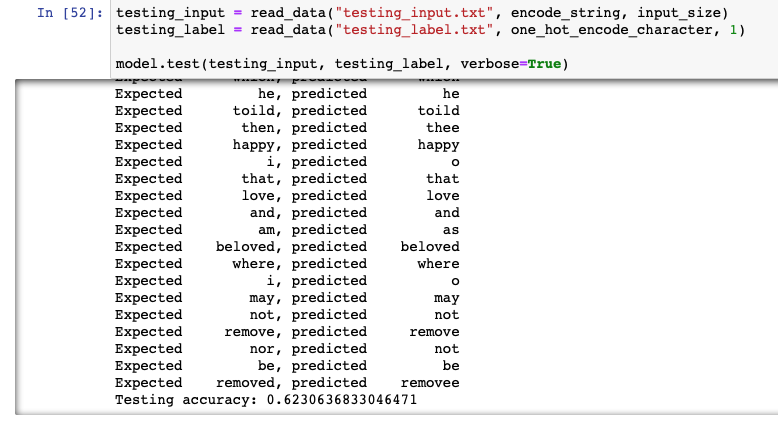

## Submission

Add your code at the correct position in the submission text file ```answers.txt```, containing only the four sections (together with the comments).

Sample code for submission:

```
# TO DO: setup for the current step
layer_input = []
weight = []

# TO DO: calculate gradients
gradients, dW, db = [], [], []

# TO DO: update weights
self.weights[0] += 0
self.biases[0] += 0

# TO DO: setup for the next step
previous_gradients = []
layer_output = []
```

**Note:** this is simply placeholder code, it won't compute what you need !

## Marking

If your implementation runs and obtains a testing accuracy of more than 0.5 then your submission will be given full marks.

Otherwise, each submitted correct section of your code will receive some part of the total marks, as follows:

```
# TO DO: setup for the current step [2 marks]
layer_input = []
weight = []

# TO DO: calculate gradients [1 mark]
gradients, dW, db = [], [], []

# TO DO: update weights [2 marks]
self.weights[0] += 0
self.biases[0] += 0

# TO DO: setup for the next step [2 marks]
previous_gradients = []
layer_output = []
```

**NOTE:** it is OK to split your code for each section over multiple lines. Also, be sure to check how exactly how ```numpy``` is imported in the code below !

In [30]:
import time
import numpy

In [31]:
# helper functions to read data
def read_data(file_name, encoding_function, expected_length):
    with open(file_name, 'r') as f:
        return numpy.array([encoding_function(row) for row in f.read().split('\n') if len(row) == expected_length])

def encode_string(s):
    return [one_hot_encode_character(c) for c in s]

def one_hot_encode_character(c):
    base = [0] * 26
    index = ord(c) - ord('a')
    if index >= 0 and index <= 25:
        base[index] = 1
    return base

def reverse_one_hot_encode(v):
    return chr(numpy.argmax(v) + ord('a')) if max(v) > 0 else ' '

In [32]:
# functions used in the neural network
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))

def sigmoid_derivative(x):
    return (1 - x) * x

def argmax(x):
    return numpy.argmax(x, axis=1)

In [33]:
class NeuralNetwork:
    def __init__(self, learning_rate=2, epochs=5000, input_size=9, hidden_layer_size=64):
        # activation function and its derivative to be used in backpropagation
        self.activation_function = sigmoid
        self.derivative_of_activation_function = sigmoid_derivative
        self.map_output_to_prediction = argmax

        # parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size

        # initialisation
        numpy.random.seed(77)

    def fit(self, X, y):
        # reset timer
        timer_base = time.time()
        
        # initialise the weights of the NN
        input_dim = X.shape[2] + self.hidden_layer_size
        output_dim = y.shape[1]

        self.weights, self.biases = [], []

        previous_layer_size = input_dim
        for current_layer_size in [self.hidden_layer_size, output_dim]:
            # random initial weights and zero biases
            weights_of_current_layer = numpy.random.randn(previous_layer_size, current_layer_size)
            bias_of_current_layer = numpy.zeros((1, current_layer_size))

            self.weights.append(weights_of_current_layer)
            self.biases.append(bias_of_current_layer)
            previous_layer_size = current_layer_size

        # train the NN
        self.accuracy_log = []

        for epoch in range(self.epochs + 1):
            outputs = self.forward_propagate(X)
            prediction = outputs.pop()

            if epoch % 100 == 0:
                accuracy = self.evaluate(prediction, y)
                print(f"In iteration {epoch}, training accuracy is {accuracy}.")
                self.accuracy_log.append(accuracy)

            # first step of back-propagation
            dEdz = y - prediction
            layer_input = outputs.pop()
            layer_output = prediction

            # calculate gradients
            dEds, dW, db = self.derivatives_of_last_layer(dEdz, layer_output, layer_input)
            
            # update weights
            self.weights[1] += self.learning_rate / X.shape[0] * dW
            self.biases[1] += self.learning_rate / X.shape[0] * db

            # setup for the next step
            previous_gradients = dEds
            layer_output = layer_input

            # back-propagation through time (unrolled)
            for step in range(self.input_size - 1, -1, -1):
                # TO DO: setup for the current step
                layer_input = numpy.concatenate((outputs.pop(),X[:,step,:]), axis=1)
                if step==self.input_size-1:
                    weight=self.weights[1][:64,:]
                else:
                    weight=self.weights[0][:64,:]
    

                # TO DO: calculate gradients
                gradients, dW, db = self.derivatives_of_hidden_layer(previous_gradients,layer_output,layer_input,weight)

                # TO DO: update weights
                self.weights[0] += self.learning_rate / X.shape[0] * dW
                self.biases[0] += self.learning_rate / X.shape[0] * db

                # TO DO: setup for the next step
                previous_gradients = gradients
                layer_output = layer_input[:,:64]

        print(f"Finished training in {time.time() - timer_base} seconds")

    def test(self, X, y, verbose=True):
        predictions = self.forward_propagate(X)[-1]

        if verbose:
            for index in range(len(predictions)):
                prefix = ''.join(reverse_one_hot_encode(v) for v in X[index])
                print(f"Expected {prefix + reverse_one_hot_encode(y[index])}, predicted {prefix + reverse_one_hot_encode(predictions[index])}")

        print(f"Testing accuracy: {self.evaluate(predictions, y)}")

    def evaluate(self, predictions, target_values):
        successful_predictions = numpy.where(self.map_output_to_prediction(predictions) == self.map_output_to_prediction(target_values))
        return successful_predictions[0].shape[0] / len(predictions) if successful_predictions else 0


    def forward_propagate(self, X):
        # initial states
        current_state = numpy.zeros((X.shape[0], self.hidden_layer_size))
        outputs = [current_state]
        
        # forward propagation through time (unrolled)
        for step in range(self.input_size):
            x = numpy.concatenate((current_state, X[:, step, :]), axis=1)
            current_state = self.apply_neuron(self.weights[0], self.biases[0], x)
            outputs.append(current_state)

        # the last layer
        output = self.apply_neuron(self.weights[1], self.biases[1], current_state)
        outputs.append(output)
        return outputs

    def apply_neuron(self, w, b, x):
        return self.activation_function(numpy.dot(x, w) + b)

    def derivatives_of_last_layer(self, dEdz, layer_output, layer_input):
        dEds = self.derivative_of_activation_function(layer_output) * dEdz
        dW = numpy.dot(layer_input.T, dEds)
        db = numpy.sum(dEds, axis=0, keepdims=True)
        return dEds, dW, db

    def derivatives_of_hidden_layer(self, layer_difference, layer_output, layer_input, weight):
        gradients = self.derivative_of_activation_function(layer_output) * numpy.dot(layer_difference, weight.T)
        dW = numpy.dot(layer_input.T, gradients)
        db = numpy.sum(gradients, axis=0, keepdims=True)
        return gradients, dW, db


In [34]:
training_input = read_data("training_input.txt", encode_string, 9)
training_label = read_data("training_label.txt", one_hot_encode_character, 1)

model = NeuralNetwork()
model.fit(training_input, training_label)

In iteration 0, training accuracy is 0.005393258426966292.
In iteration 100, training accuracy is 0.0.
In iteration 200, training accuracy is 0.0.
In iteration 300, training accuracy is 0.0.
In iteration 400, training accuracy is 0.0.
In iteration 500, training accuracy is 0.3096629213483146.
In iteration 600, training accuracy is 0.3649438202247191.
In iteration 700, training accuracy is 0.37258426966292135.
In iteration 800, training accuracy is 0.39280898876404496.
In iteration 900, training accuracy is 0.4049438202247191.
In iteration 1000, training accuracy is 0.42067415730337077.
In iteration 1100, training accuracy is 0.4341573033707865.
In iteration 1200, training accuracy is 0.4310112359550562.
In iteration 1300, training accuracy is 0.4543820224719101.
In iteration 1400, training accuracy is 0.46202247191011236.
In iteration 1500, training accuracy is 0.46831460674157305.
In iteration 1600, training accuracy is 0.4898876404494382.
In iteration 1700, training accuracy is 0.509

In [35]:
testing_input = read_data("testing_input.txt", encode_string, 9)
testing_label = read_data("testing_label.txt", one_hot_encode_character, 1)

model.test(testing_input, testing_label, verbose=True)

Expected         so, predicted         so
Expected         is, predicted         it
Expected         it, predicted         it
Expected        not, predicted        not
Expected       with, predicted       with
Expected         me, predicted         my
Expected         as, predicted         as
Expected       with, predicted       with
Expected       that, predicted       that
Expected       muse, predicted       must
Expected     stirrd, predicted     stirrs
Expected         by, predicted         be
Expected          a, predicted          o
Expected    painted, predicted    painted
Expected     beauty, predicted     beauty
Expected         to, predicted         to
Expected        his, predicted        his
Expected      verse, predicted      verse
Expected        who, predicted        who
Expected     heaven, predicted     heaves
Expected     itself, predicted     itself
Expected        for, predicted        for
Expected   ornament, predicted   ornament
Expected       doth, predicted    

Expected       keep, predicted       keet
Expected         so, predicted         so
Expected      chary, predicted      chard
Expected         as, predicted         as
Expected     tender, predicted     tender
Expected      nurse, predicted      nurst
Expected        her, predicted        her
Expected       babe, predicted       babe
Expected       from, predicted       from
Expected     faring, predicted     faring
Expected        ill, predicted        ill
Expected    presume, predicted    presume
Expected        not, predicted        not
Expected         on, predicted         or
Expected        thy, predicted        the
Expected      heart, predicted      heart
Expected       when, predicted       whet
Expected       mine, predicted       mine
Expected         is, predicted         it
Expected      slain, predicted      slais
Expected       thou, predicted       thou
Expected     gavest, predicted     gavest
Expected         me, predicted         my
Expected      thine, predicted    